# Deep learning project

## Kunskapskontroll 2

### Detecting emotion on images or video of human faces.

To start with we use the following dataset from Kaggle:

'Face expression recognition dataset'

LINK:
https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

Supplemental dataset from :
    
http://mmlab.ie.cuhk.edu.hk/projects/socialrelation/index.html

The project is based on the example from this Github: https://github.com/akmadan/Emotion_Detection_CNN
 and the Youtube video: https://www.youtube.com/watch?v=Bb4Wvl57LIk

## Importing libraries

In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import itertools
from collections import defaultdict

# Importing Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import img_to_array,  load_img

from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator 
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model,Sequential




In [4]:
seed = 42

In [5]:
# size of the images
picture_size = 48

In [6]:
# path to the image folder
folder_path = "content/"

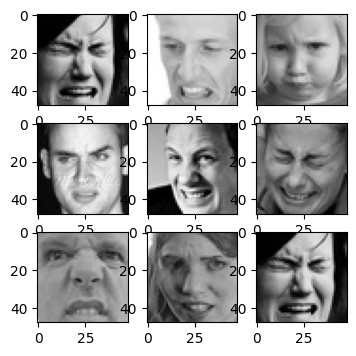

In [7]:
expression = 'disgust'

plt.figure(figsize= (4,4))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

## Making Training and Validation Data

In [24]:
batch_size = 64

In [25]:
expressions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

### We need to make training and validation sets. and make sure images are proper size etc.

80% of the images for training and 20% for validation.

In [26]:
import numpy as np

# Function to preprocess an image (convert to grayscale and rescale)
def preprocess_image(image, label):
    # Convert image to grayscale
    gray_image = tf.image.rgb_to_grayscale(image)
    # Rescale pixel values to be between 0 and 1
    gray_image /= 255.0
    return gray_image, label

In [27]:
# Define a generator function to load and preprocess the data
def data_generator(dataset, preprocess_fn):
    for image_batch, label_batch in dataset:
        yield preprocess_fn(image_batch, label_batch)

# Load the dataset without preprocessing
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255
)

In [28]:
train_ds = datagen.flow_from_directory(
    folder_path + "train",
    target_size=(picture_size, picture_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 23060 images belonging to 7 classes.


In [29]:
val_ds = datagen.flow_from_directory(
    folder_path + "train",
    target_size=(picture_size, picture_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 5761 images belonging to 7 classes.


In [40]:
# Function to limit the dataset size
def limit_dataset(dataset, limit):
    return dataset.take(limit)

# Define the desired dataset size
desired_dataset_size = 500

# Create limited datasets with the desired size
limited_train_dataset = limit_dataset(train_dataset, desired_dataset_size)
limited_val_dataset = limit_dataset(val_dataset, desired_dataset_size)

Limited Train Dataset Size: 500
Limited Validation Dataset Size: 500


In [42]:
# Function to count the elements in a dataset
def count_elements(dataset):
    count = 0
    for _ in dataset:
        count += 1
    return count

# Print the sizes of the limited datasets
print("Limited Train Dataset Size:", count_elements(limited_train_dataset))
print("Limited Validation Dataset Size:", count_elements(limited_val_dataset))


Limited Train Dataset Size: 500
Limited Validation Dataset Size: 500


In [43]:
# Function to print the shape of the tensors in a dataset
def print_tensor_shapes(dataset):
    for image_batch, labels_batch in dataset.take(1):
        print("Image batch shape:", image_batch.shape)
        print("Labels batch shape:", labels_batch.shape)

# Print the shapes of the tensors in the limited datasets
print("Shapes of tensors in the Limited Train Dataset:")
print_tensor_shapes(limited_train_dataset)

print("\nShapes of tensors in the Limited Validation Dataset:")
print_tensor_shapes(limited_val_dataset)

Shapes of tensors in the Limited Train Dataset:
Image batch shape: (64, 48, 48, 1)
Labels batch shape: (64, 7)

Shapes of tensors in the Limited Validation Dataset:
Image batch shape: (1, 48, 48, 1)
Labels batch shape: (1, 7)


#### The image_batch is a tensor of the shape (32, 48, 48, 1).

This is a batch of 64 images of shape 48x48x3 (the last dimension refers to color channels greyscale). 

The label_batch is a tensor of the shape (32, 7), these are corresponding 7 labels to the 32 images.

In [44]:
class_names = list(train_ds.class_indices.keys())
print(class_names)


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Model Building

### First model.

In [45]:

no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(learning_rate = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_12 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 128)      

## Fitting the Model with Training and Validation Data

In [46]:
epochs = 48

In [47]:
checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [48]:
for image_batch, labels_batch in train_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)


Image batch shape: (64, 48, 48, 1)
Labels batch shape: (64, 7)


In [49]:
model.compile(run_eagerly=True, optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [55]:
# Train the model using fit with generators
history = model.fit(
    limited_train_dataset,
    epochs=epochs,
    validation_data=limited_val_dataset,
    validation_steps=validation_steps,
    callbacks=[checkpoint]
)

Epoch 1/48
    500/Unknown - 385s 769ms/step - loss: 1.9817 - accuracy: 0.2373WARNING:tensorflow:Can save best model only with val_acc available, skipping.
500/500 [==============================] - 385s 769ms/step - loss: 1.9817 - accuracy: 0.2373
Epoch 2/48
500/500 [==============================] - 384s 768ms/step - loss: 1.7981 - accuracy: 0.3028
Epoch 3/48
500/500 [==============================] - 383s 767ms/step - loss: 1.6626 - accuracy: 0.3582
Epoch 4/48
500/500 [==============================] - 386s 772ms/step - loss: 1.5564 - accuracy: 0.4028
Epoch 5/48
500/500 [==============================] - 386s 773ms/step - loss: 1.4757 - accuracy: 0.4342
Epoch 6/48
500/500 [==============================] - 385s 771ms/step - loss: 1.4046 - accuracy: 0.4625
Epoch 7/48
500/500 [==============================] - 391s 781ms/step - loss: 1.3353 - accuracy: 0.4888
Epoch 8/48
500/500 [==============================] - 382s 765ms/step - loss: 1.2856 - accuracy: 0.5082
Epoch 9/48
500/500 [===

## Plotting Accuracy & Loss

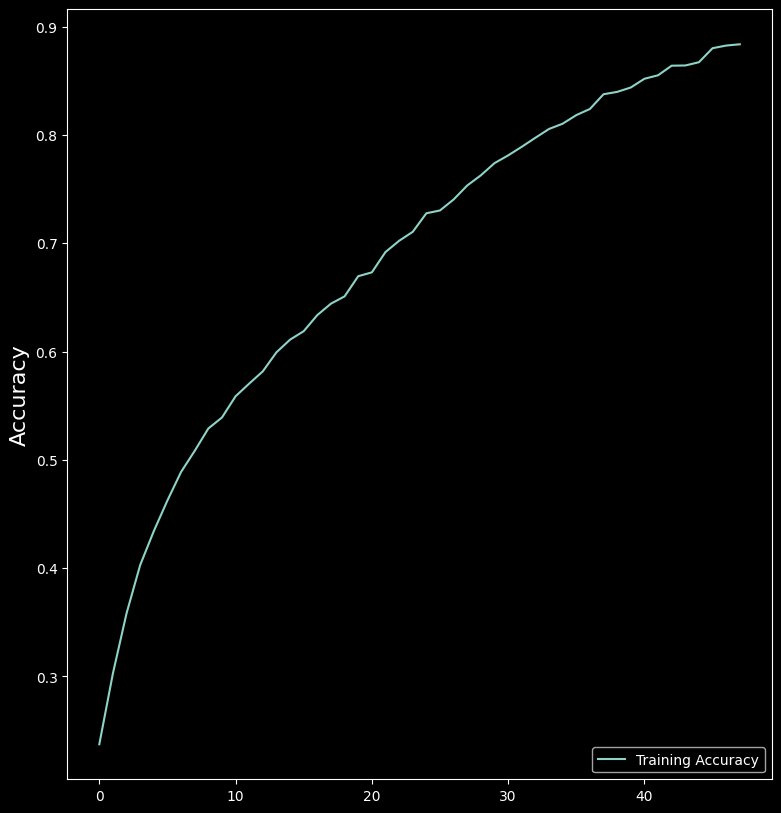

In [59]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend(loc='lower right')
plt.show()

## second model
Using a pre-trained model ontop of our own

In [62]:
from tensorflow.keras.applications import VGG16

model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


### model ensemble

In [63]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Dense, Flatten, Reshape

# Assume you have model (your custom model) and model_VGG16 (VGG16 without top layer)

# Flatten the VGG16 output to a 2D tensor
flattened_vgg16_output = Flatten()(model_VGG16.output)

# Concatenate features from your custom model and VGG16
concatenated_features = Concatenate()([model.output, flattened_vgg16_output])

# Add a classifier on top of concatenated features
output = Dense(7, activation='softmax')(concatenated_features)  # Assuming 7 emotion classes

# Create the new model
merged_model = Model(inputs=[model.input, model_VGG16.input], outputs=output)

# Compile the model
merged_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
merged_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_8_input (InputLayer  [(None, 48, 48, 1)]          0         []                            
 )                                                                                                
                                                                                                  
 conv2d_8 (Conv2D)           (None, 48, 48, 64)           640       ['conv2d_8_input[0][0]']      
                                                                                                  
 batch_normalization_12 (Ba  (None, 48, 48, 64)           256       ['conv2d_8[0][0]']            
 tchNormalization)                                                                                
                                                                                              

In [64]:
# Print the shapes to confirm preprocessing
for image_batch, labels_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(64, 48, 48, 1)
(64, 7)


In [ ]:
# Assuming you have prepared your datasets 'train_dataset' and 'val_dataset'

# Adjust the input shape in the dataset
train_dataset = train_dataset.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))
val_dataset = val_dataset.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))

# Fit the model
history = merged_model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
)

# Evaluate the model
loss, accuracy = merged_model.evaluate(val_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)